# TP VIC 2D

In [8]:
import numpy as np
import scipy.sparse as sps
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from pyxel import Image
from bsplyne import new_circle

## I. Definition of the main operators

### 1) Image

We use the image from the article of J. Réthoré and M. François, stored in `im.pix` here.

<small>J. Réthoré, M. François, Curve and boundaries measurement using B-splines and virtual images, Optics and Lasers in Engineering, Volume 52, 2014</small>

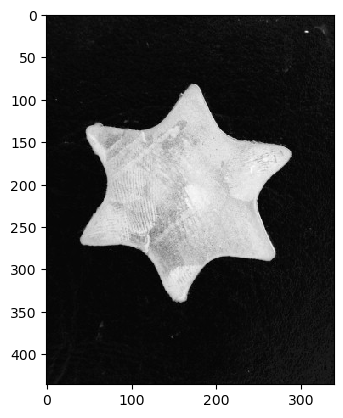

In [9]:
im = Image("image.jpg")
im.Load()
im.Plot()

The image $I$ is a grid of $M_1\times M_2$ pixels.
A sub-pixel interpolator $f$ is created from this image:
$$f : \begin{matrix}
    [0, M_1]\times [0, M_2] & \to & [0, 255] \\
    (x, y) & \mapsto & f(x, y) \\
\end{matrix} \quad .$$

Here, the data is centered on the half pixel: $f(x + 0.5, y + 0.5) = I[x, y]$.

The gradient of the interpolator is also defined for later as $\nabla f$.

Define the variables `M1` and `M2` as explained.

In [10]:
M1, M2 = im.pix.shape
print(f"M1 = {M1}\nM2 = {M2}")

M1 = 436
M2 = 339



Let's also define, the functions `f` and `grad_f` that both takes an array of $x$ and $y$ values stacked as $(x_0, ..., x_n, y_0, ..., y_n)^T$ as input.

`f` returns an array of graylevels corresponding to the positions given as input and `grad_f` returns two arrays containning both derivatives w.r.t. $x$ and $y$.

We can use the methods `Interp` and `InterpGrad` from the `Image` class.

In [11]:
def f(xy):
    return im.Interp(*np.split(xy - 0.5, 2))

center_pix = np.array([15.5, 100.5])
f_pix = f(center_pix)
print(f"f({center_pix}) = {f_pix}\nI{(center_pix - 0.5).astype('int')} = {im.pix[tuple((center_pix - 0.5).astype('int'))]}")

f([ 15.5 100.5]) = [10.]
I[ 15 100] = 10.0


In [12]:
def grad_f(xy):
    grad_x, grad_y = im.InterpGrad(*np.split(xy - 0.5, 2))
    return grad_x, grad_y

grad_f_pix = grad_f(center_pix)
eps = 1e-7
eps_x, eps_y = eps*np.eye(2)
finite_diff_f_pix = (f(center_pix + eps_x) - f(center_pix - eps_x))/(2*eps), (f(center_pix + eps_y) - f(center_pix - eps_y))/(2*eps)
print(f"""
┌───────────────┬───────────────┬───────────────┐
│               │    grad_x     │    grad_y     │
├───────────────┼───────────────┼───────────────┤
│ grad_f_pix    │ {grad_f_pix[0][0]:.10f} │ {grad_f_pix[1][0]:.10f} │
├───────────────┼───────────────┼───────────────┤
│ finite_diff   │ {finite_diff_f_pix[0][0]:.10f} │ {finite_diff_f_pix[1][0]:.10f} │
└───────────────┴───────────────┴───────────────┘
""")


┌───────────────┬───────────────┬───────────────┐
│               │    grad_x     │    grad_y     │
├───────────────┼───────────────┼───────────────┤
│ grad_f_pix    │ -1.6481991979 │ -6.0848266524 │
├───────────────┼───────────────┼───────────────┤
│ finite_diff   │ -1.6481991949 │ -6.0848263050 │
└───────────────┴───────────────┴───────────────┘



### 2) B-Spline and nomal neighborhood

Let's define the contour as a B-spline parametric curved line.

A B-spline is defined from its control points, its degree (or order) and its knot vector. Here, only the control points are covered for simplicity.

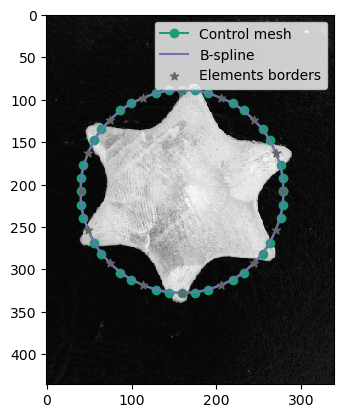

In [13]:
spline, ctrl_pts = new_circle([M2/2 - 10, M1/2 - 10, 0], [0, 0, 1], (M2 - 100)/2)
ctrl_pts = spline.orderElevation(ctrl_pts[:-1], [1])
im.Plot()
plt.gca().get_children()[9].set_zorder(-10)
spline.plotMPL(ctrl_pts, ax=plt.gca())

#### a) B-spline mapping

This B-spline is a linear combination of functions, called basis functions and noted $N$. This sum is usually weighted by the control points stored in $X$, but can be weighted by anything to define a field.
Lets define the B-spline mapping of a set of parameters (e.g. the control points) as:
$$\bm{x}(X) : \begin{matrix}
    [0, 1] & \to & \mathbb{R}^2 \\
    \xi & \mapsto & N(\xi) X \\
\end{matrix} \quad ,$$

where:
* $X \in \mathbb{R}^{2n_{bf}}$ contains the stacked coordinates of the control points as $X = (X^x_0, ..., X^x_{n_bf}, X^y_0, ..., X^y_{n_bf})^T$, or any other field.
* $N(\xi) \in \mathbb{R}^{2\times 2n_{bf}}$ is a matrix containing the B-spline basis functions. It is a sparse matrix thanks to the compact support of the functions.

Given a displacement of the control points $U \in \mathbb{R}^{2n_{bf}}$, the displacement field can be expressed as $\bm{x}(U)$.

Let's first define `X` from `ctrl_pts`.

In [14]:
X = ctrl_pts.ravel()

For ease of use, let's define a function `N` vectorized such that it takes an array of $\xi$ values as input and outputs a sparse matrix $\bm{N}$.
This matrix is just multiple $N$ matrices stacked vertically and rearranged such that:
$$\bm{N} X = (\bm{x}^x(\xi_0), ..., \bm{x}^x(\xi_{n_{\xi}}), \bm{x}^y(\xi_0), ..., \bm{x}^y(\xi_{n_{\xi}}))^T.$$

To define it we can use the method `DN` from the `BSpline` class, which create a sparse matrix $\bm{N^e}$ such that :
$$\bm{N^e} \begin{pmatrix}X^x_0 \\ \vdots \\ X^x_{n_bf}\end{pmatrix} = \begin{pmatrix} \bm{x}^x(\xi_0) \\ \vdots \\ \bm{x}^x(\xi_{n_{\xi}}) \end{pmatrix}$$

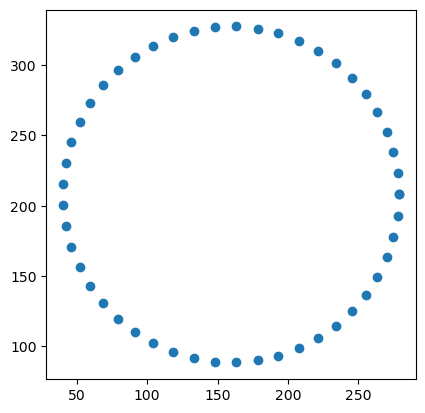

In [15]:
def N(xi):
    return sps.block_diag([spline.DN([xi])]*2)

xi = np.linspace(0, 1, 50)
N_xi = N(xi)
plt.scatter(*np.split(N_xi@X, 2))
plt.gca().set_aspect(1)

#### b) Normal neighborhood

The normal neighborhood is defined as a width of search along the normal of the B-spline curve, of length $2h$ pixels. Let's define the width of search:

In [16]:
h = 20


To do this, let's define a local basis. It is defined on a configuration $X$ (initial or deformed) as:
$$\left \{ \begin{matrix} 
    \bm{t}(X)(\xi) & = & N'(\xi) X \\ 
    \bm{n}(X)(\xi) & = & R \frac{\bm{t}(X)(\xi)}{\|\bm{t}(X)(\xi)\|} 
\end{matrix} \right . ,$$
With $R = \begin{pmatrix} 0 & -1 \\ 1 & 0 \end{pmatrix}$.

Using the normal $\bm{n}$ the normal neighborhood is defined on a configuration $X$ as the sum of the B-spline mapping with a linear mapping along the normal:
$$\bm{x^n}(X) : \begin{matrix}
    [0, 1]\times[-h, h] & \to & \mathbb{R}^2 \\
    (\xi, \gamma) & \mapsto & \bm{x}(X)(\xi) + \gamma \bm{n}(X)(\xi) \\
\end{matrix} \quad .$$

Lets create a function `x_n` to compute the normal neighborhood of the B-spline from a set of $\xi$ and $\gamma$ values.
The result is a vector stacking the $x$ and $y$ coordinates of the points in the normal neighborhood.
Those points are computed at every combination of $\xi$ and $\gamma$ from the input.

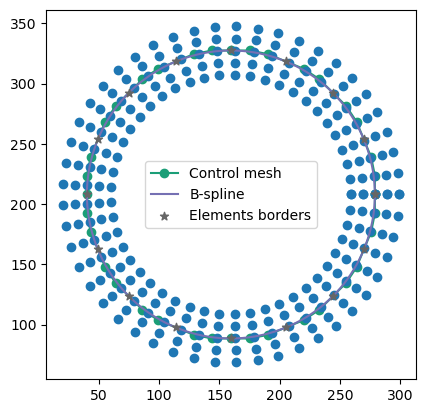

In [17]:
def x_n(xi, gamma):
    x = spline(X.reshape((2, -1)), [xi], k=[0])
    t = spline(X.reshape((2, -1)), [xi], k=[1])
    n = np.vstack((-t[1], t[0]))/np.linalg.norm(t, axis=0)
    ones = np.ones_like(gamma)
    x_result = np.kron(x[0], ones) + np.kron(n[0], gamma)
    y_result = np.kron(x[1], ones) + np.kron(n[1], gamma)
    xy = np.hstack((x_result, y_result))
    return xy

xi = np.linspace(0, 1, 50)
gamma = np.linspace(-h, h, 5)
xy = x_n(xi, gamma)
fig, ax = plt.subplots()
spline.plotMPL(X.reshape((2, -1)), ax=ax)
ax.scatter(*np.split(xy, 2))

From here, the initial control points are considered constant, allowing us to drop certain dependances, simplifying the notations.
To do so, bold operators evaluated in the control points will become regular (e.g. $n = \bm{n}(X)$).

A displacement of the normal neighborhood can be expressed as the difference between the intitial and deformed configuration normal neigborhoods:
$$\bm{u^n}(U) = \bm{x^n}(X + U) - x^n .$$

This displacement is partly induced by the rotation of both the normal and the tangent vectors by a same angle $\bm{\theta}$.
The displacement is then retrieved from this rotation with:
$$\bm{u^n}(U)(\xi, \gamma) \approx \bm{x}(U) - \gamma \bm{\theta}(U) \frac{t}{\|t\|} .$$

This angle can be approximated using a small rotation hypothesis:
$$\bm{\theta}(U) \approx \frac{n \cdot \bm{t}(U)}{\|\bm{t}(X + U)\|} \approx \frac{n \cdot \bm{t}(U)}{\|t\|} ,$$
which gives the linear dependance on $U$:
$$\bm{\theta}(U)(\xi) \approx \frac{X^T N'(\xi)^T R^T \cdot N'(\xi)}{\|N'(\xi) X\|^2} U = \Theta(\xi) U .$$

In the end, the displacement of a point in the normal neighborhood is approximated by:
$$\bm{u^n}(U) = J^n U ,$$
where $J^n$ is given as:
$$J^n(\xi, \gamma) = N(\xi) - \gamma \frac{t(\xi)}{\|t(\xi)\|} \Theta(\xi)^T$$

Lets define the function `J_n` that create the matrix $\mathcal{J^n}$ from a set of $\xi$ and $\gamma$ values using the Kronecker product.

$\mathcal{J^n}(\xi, \gamma)$ is defined in the same way as $\bm{N}$ in the sense that it gathers the matrices $J^n$ evaluated on every combinations of $\xi$ and $\gamma$ given as input.

Due to its complexity, it is given here:

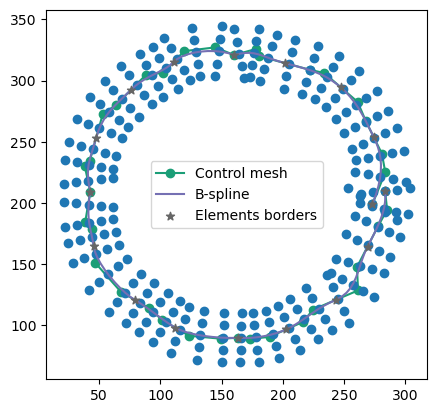

In [18]:
def J_n(xi, gamma):
    N_elem = spline.DN([xi], k=[0])
    ones = np.ones_like(gamma)
    part_a = sps.block_diag([sps.kron(N_elem, ones[:, None])]*2)
    N_prime_elem = spline.DN([xi], k=[1])
    t = X.reshape((2, -1))@N_prime_elem.T
    norm = np.linalg.norm(t, axis=0)
    norm_sq = norm*norm
    Theta = sps.hstack((N_prime_elem.multiply((-t[1]/norm_sq)[:, None]), N_prime_elem.multiply((t[0]/norm_sq)[:, None])))
    t_x_Theta = Theta.multiply((t[0]/norm)[:, None])
    t_y_Theta = Theta.multiply((t[1]/norm)[:, None])
    part_b_x = sps.kron(t_x_Theta, gamma[:, None])
    part_b_y = sps.kron(t_y_Theta, gamma[:, None])
    part_b = sps.vstack((part_b_x, part_b_y))
    return part_a - part_b

xi = np.linspace(0, 1, 50)
gamma = np.linspace(-h, h, 5)
U = np.random.normal(size=X.size)*5
xy = x_n(xi, gamma) + J_n(xi, gamma)@U
fig, ax = plt.subplots()
spline.plotMPL((X + U).reshape((2, -1)), ax=ax)
ax.scatter(*np.split(xy, 2))

### 3) Virtual Image

The virtual image is defined as the target gray level transition profile. It is defined on the width of search $[-h, h]$ as:
$$g : \begin{matrix}
    [-h, h] & \to & [0, 255] \\
    \gamma & \mapsto & g(\gamma) \\
\end{matrix} \quad .$$

This profile does not need to be perfect. The algorithm will find the solution that fits best the mean encountered profile to the virtual image.

In this case, by looking at the image, a step function from dark gray to light gray may be adapted: such profile can never be obtained but it will be approached as well as possible.

Let's make a histogram of the image first to set the graylevels of interest.

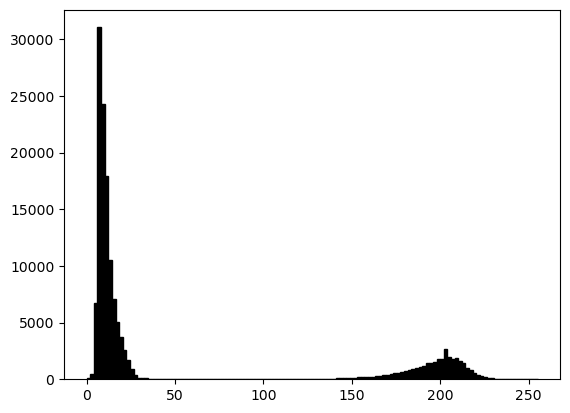

In [19]:
im.PlotHistogram()

Let's create the function `g` that takes an array of $\gamma$ values as input and returns an array containning their corresponding virtual image graylevels.

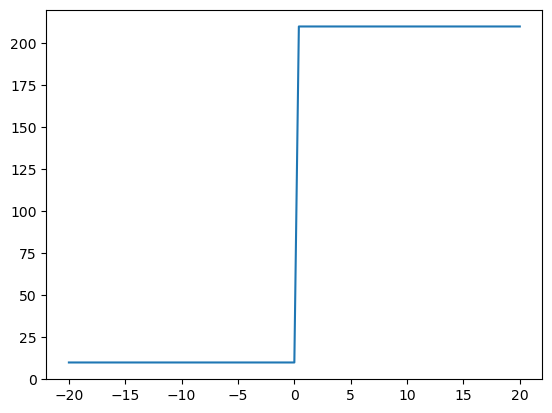

In [20]:
def g(gamma):
    fg = 210
    bg = 10
    return bg + (fg - bg)*(gamma>0)

gamma = np.linspace(-h, h, 101)
plt.plot(gamma, g(gamma))

## II. Problem definition

The problem at hand will be to find a displacement of the contol points $U$ to fit the normal neighborhood graylevels to the virtual image.
This means to minimize a greylevel error given by:
$$E_{VIC}(U) = \frac{1}{2} \int_0^1 \int_{-h}^h \bm{r}(U)(\xi, \gamma)^2 d\gamma \frac{d\xi}{\|x'(\xi)\|} ,$$
where the residu is given by $\bm{r}(U) = f\bigg(x^n + J^n U\bigg) - g$.

Let's make a function `r` that creates a residu vector from $x^n$, $J^n$, $U$ and the evaluation of $g$.

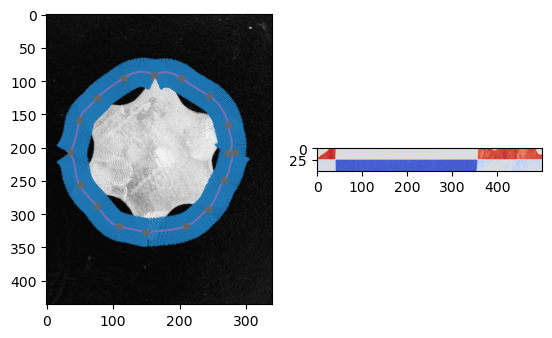

In [21]:
def r(xn, Jn, U, g_gamma):
    return f(xn + Jn@U) - g_gamma

xi = np.linspace(0, 1, 500)
gamma = np.linspace(-h, h, 50)
U = np.random.normal(size=X.size)*5
xn = x_n(xi, gamma)
Jn = J_n(xi, gamma)
g_gamma = g(np.kron(np.ones_like(xi), gamma))
r_eval = r(xn, Jn, U, g_gamma)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im.pix, cmap='gray')
spline.plotMPL((X + U).reshape((2, -1)), ax=ax1)
ax1.scatter(*np.split(xn + Jn@U, 2), s=.1)
ax1.get_legend().remove()
ax2.imshow(r_eval.reshape((xi.size, gamma.size)).T, cmap="coolwarm")

In order to solve this problem a Gauss-Newton method is applied to do so, the gradient of the residu is needed, which is given by:
$$\nabla\bm{r}(U) = \nabla f \bigg(x^n + J^n U\bigg) J^n .$$

Let's make a function `grad_r` that makes this from $x^n$, $J^n$ and $U$. The result is a matrix because there is one gradient in each row, corresponding to each $(\xi, \gamma)$ pair.

In [22]:
def grad_r(xn, Jn, U):
    gradx, grady = grad_f(xn + Jn@U)
    n = Jn.shape[0]
    return Jn[:n//2].multiply(gradx[:, None]) + Jn[n//2:].multiply(grady[:, None])

grad_r(xn, Jn, U)

<25000x74 sparse matrix of type '<class 'numpy.float64'>'
	with 199750 stored elements in Compressed Sparse Row format>

The gradient of the cost function $E_{VIC}$  is then expressed by:
$$\nabla E_{VIC}(U) \approx \int_0^1 \int_{-h}^h \bm{r}(U)(\xi, \gamma) \nabla\bm{r}(U)(\xi, \gamma) d\gamma \frac{d\xi}{\|x'(\xi)\|}$$

The Gauss-Newton algorithm is based on the convergence of this residu to $0$. If this is the case, the Hessian matrix of the cost function can be approximated by:
$$H E_{VIC}(U) \approx \int_0^1 \int_{-h}^h \nabla\bm{r}(U)(\xi, \gamma) \nabla\bm{r}(U)^T(\xi, \gamma) d\gamma \frac{d\xi}{\|x'(\xi)\|}$$

Let's make a function that computes these operators:

In [23]:
def E_vic(xn, Jn, U, g_gamma, scaled_intg_weights):
    r_eval = r(xn, Jn, U, g_gamma)
    grad_r_eval = grad_r(xn, Jn, U)
    grad_E = grad_r_eval.multiply((r_eval*scaled_intg_weights)[:, None]).sum(axis=0).A.ravel()
    hess_E = grad_r_eval.multiply(scaled_intg_weights[:, None]).T@grad_r_eval
    return grad_E, hess_E


This problem is ill-posed due to the non uniqueness of the solution. To solve this issue, let's define a regularization term: a 2D infinitely thin beam of rigidity matrix $K$.

This matrix is computed through a Gauss-Legendre integration scheme
This rigidity is coded in the function `K_rigidity` below, and stored in the variable `K`:

In [24]:
def K_rigidity(xi, intg_weights):
    N_prime_elem = spline.DN([xi], k=[1])
    t = X.reshape((2, -1))@N_prime_elem.T
    norm_sq = (t*t).sum(axis=0)
    N_prime = sps.block_diag([N_prime_elem]*2)
    alpha = N_prime.multiply((t/norm_sq[None, :]).ravel()[:, None])
    K_result = alpha.multiply(np.hstack([intg_weights/np.sqrt(norm_sq)]*2)[:, None]).T@alpha
    return K_result

(xi,), (dxi,) = spline.gauss_legendre_for_integration()
K = K_rigidity(xi, dxi)

## III. Problem resolution

With the regularisation term included, the problem can be written as the following:
$$U^\star = \arg \min_{U \in \mathbb{R}^{2n_{bf}}} E_{VIC}(U) + \frac{\rho}{2} U^T K U$$

Let's define `rho`:

In [25]:
rho = 10_000


The Virtual Image Correlation term is integrated using a Riemann scheme. Let's define this discretization:

In [26]:
(xi,), (dxi,) = spline.linspace_for_integration(n_eval_per_elem=50)
gamma = np.linspace(-h, h, 50)
dgamma = 2*h/50*np.ones_like(gamma)
scaled_intg_weights = np.kron(dxi/np.linalg.norm(spline(X.reshape((2, -1)), [xi], k=[1]), axis=0), dgamma)

Finally, let's solve the problem with a Gauss-Newton method:

/tmp/ipykernel_43626/3363496546.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  displ = np.linalg.norm(dU)/np.linalg.norm(U)


Iteration 0: relative displacement of inf
Iteration 5: relative displacement of 0.6464839909906093
Iteration 10: relative displacement of 0.2175378076901444
Iteration 15: relative displacement of 0.1847502853288732
Iteration 20: relative displacement of 0.28466020491633937
Iteration 25: relative displacement of 0.11521377103712421
Iteration 30: relative displacement of 0.17279654089224494
Iteration 35: relative displacement of 0.24060099583248049
Iteration 40: relative displacement of 0.08202156784210264
Iteration 45: relative displacement of 0.14448340506053095
Iteration 50: relative displacement of 0.13175677341553482
Iteration 55: relative displacement of 0.11688614538613161
Iteration 60: relative displacement of 0.17421256847887437
Iteration 65: relative displacement of 0.1124882450935318
Iteration 70: relative displacement of 0.07436775758285466
Iteration 75: relative displacement of 0.09915764333175198
Iteration 80: relative displacement of 0.12221636567792701
Iteration 85: relat

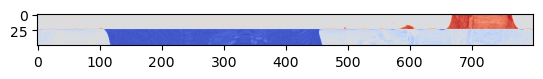

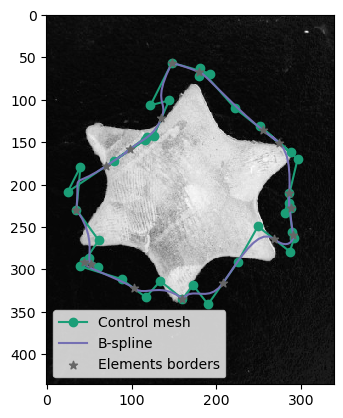

In [27]:
U = np.zeros_like(X)
xn = x_n(xi, gamma)
Jn = J_n(xi, gamma)
g_gamma = g(np.kron(np.ones_like(xi), gamma))
eps = 5e-3
for i in range(100):
    grad_E, hess_E = E_vic(xn, Jn, U, g_gamma, scaled_intg_weights)
    A = hess_E + rho*K
    b = -grad_E - rho*U.T@K
    dU = spsolve(A, b)
    displ = np.linalg.norm(dU)/np.linalg.norm(U)
    U += dU
    if i%5==0 or displ<eps:
        print(f"Iteration {i}: relative displacement of {displ}")
    if displ<eps:
        break
r_eval = r(xn, Jn, U, g_gamma)
plt.imshow(r_eval.reshape((xi.size, gamma.size)).T, cmap="coolwarm")
plt.show()
im.Plot()
plt.gca().get_children()[9].set_zorder(-10)
spline.plotMPL((X + U).reshape((2, -1)), ax=plt.gca())